In [1]:
import numpy as np
import random
from scipy.fft import fft, fftfreq
import jax
import jax.numpy as jnp
import optax
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import StronglyEntanglingLayers
from IPython.display import clear_output
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas

# Generate data

In [2]:
# Constants
NUM_POINTS = 2000
NUM_DIMENSIONS = 5
CUSTOM_DATASET = False

In [3]:
def generate_non_uniform_fourier_series(num_frequencies: int, max_frequency: float):
    """Generate function f(x) that returns a sum of cosines with
    random amplitudes, frequencies and phases."""
    
    frequencies = [max_frequency * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    amplitudes = [random.random() for _ in range(num_frequencies)]
    phases = [2 * np.pi * random.random() for _ in range(num_frequencies)]
    # discontinuities = [NUM_POINTS * SAMPLE_SPACING * np.random.random(NUM_DIMENSIONS) for _ in range(num_frequencies)]
    print(f"Frequencies: {frequencies}")
    print(f"Amplitudes: {amplitudes}")
    print(f"Phases: {phases}")
    # print(f"Discontinuities: {discontinuities}")
    def f(x: np.ndarray):
        res = 0
        for frequency, amplitude, phase in zip(frequencies, amplitudes, phases):
            res += 1 * np.cos(np.dot(x, frequency) + phase)
        return res
    return f, frequencies

In [4]:
def generate_regression_data(inputs: np.ndarray, noise: float = 0):
    """Function used to generate noisy data."""
    data = np.array([f(input) for input in inputs])
    # add some random noise to data
    noisy_data = data + np.random.normal(0, noise, data.shape)
    return data, noisy_data

In [5]:
# Data
scaler = StandardScaler()
MAX_FREQUENCY = 5
if CUSTOM_DATASET:
    f, freqs = generate_non_uniform_fourier_series(num_frequencies=3, max_frequency=MAX_FREQUENCY)
    X = np.random.random((NUM_POINTS, NUM_DIMENSIONS)) * (100 / MAX_FREQUENCY)
    labels, Y = generate_regression_data(inputs=X, noise=0.1)
else:
    pp=pandas.read_csv('../data/airfoil_self_noise.dat', delimiter="\t", decimal=".")
    data = pp.to_numpy()
    X = data[:, :-1]
    Y = data[:, -1]
    
X = scaler.fit_transform(X)

In [6]:
# Plot
if CUSTOM_DATASET:
    all_x = np.linspace(0, 100/ MAX_FREQUENCY, 10000)
    plt.plot(all_x, [f([x] + [0] * (NUM_DIMENSIONS - 1)) for x in all_x])
    plt.show()

In [7]:
# # Compute peaks of CDFT
# half_y_dft = np.abs(y_dft[NUM_POINTS // 2 + 1:])
# rel_height = 1/3
# max_height = np.max(half_y_dft)
# peak_indices, _ = find_peaks(half_y_dft, height=rel_height * max_height)
# if len(peak_indices) > 0:
#     max_peak_idx = np.max(peak_indices)
#     peak_width = peak_widths(x=half_y_dft, peaks=[max_peak_idx], rel_height=0.9)[0]
#     cutoff_frequency = np.max(x_dft[round(max_peak_idx + peak_width[0])])
# else:
#     cutoff_frequency = 0.1
# print(f"Cutoff frequency: {cutoff_frequency}")

# Random fourier features

In [51]:
gamma = 1e-8
ndim = 5000

In [52]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

def cost(clf, input_data, labels):
    """Cost function."""
    predictions = clf.predict(input_data)
    return square_loss(labels, predictions)

In [53]:
score = 0
MAX_NUM_FREQUENCIES = 10
while score < 0.1:
    rbf_feature = RBFSampler(gamma=gamma, n_components=ndim)
    X_features = rbf_feature.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2)
    non_zero_coeffs = []
    alpha = 1
    while len(non_zero_coeffs) < MAX_NUM_FREQUENCIES and alpha > 1e-3:
        clear_output(wait=True)
        print(f"alpha = {alpha}")
        print(f"gamma: {gamma}")
        print(f"score: {score}")
        alpha /= 1.5
        clf = Lasso(alpha=alpha)
        clf.fit(X_train, Y_train)
        betas = clf.coef_
        non_zero_coeffs = betas[betas != 0]
    score = clf.score(X_test, Y_test)
    gamma *= 2

clear_output(wait=True)
lasso_loss = cost(clf, X_test, Y_test)
print(f"Loss: {lasso_loss}")
print(f"Fitting score: {score}")
print(f"Number of non-zero coefficients: {len(non_zero_coeffs)}")

Loss: 34.67249298095703
Fitting score: 0.29178810297798263
Number of non-zero coefficients: 2


In [11]:
# Get weights of feature space
weights = rbf_feature.random_weights_
# Filter coefficients
REL_THRESHOLD = 0.2
indices = np.abs(betas) >= np.max(np.abs(betas)) * REL_THRESHOLD
betas = betas[indices]
weights = weights[:, indices]

In [12]:
cutoff_frequencies = np.sort(np.max(np.abs(weights), axis=1))
print(f"Cutoff freqs: {cutoff_frequencies}")
if CUSTOM_DATASET:
    print(f"Maximum freqs: {np.max(freqs, axis=0)}")

Cutoff freqs: [0.00161178 0.00398851 0.00517593 0.00731426 0.00919297]


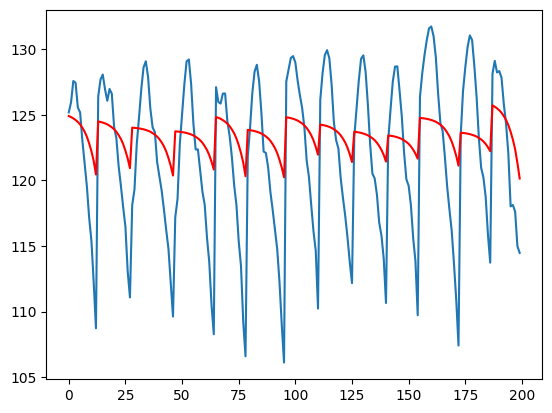

In [13]:
DIM = 1
plt.plot(Y[:200])
plt.plot(clf.predict(X_features[:200]), color="red")

In [38]:
# plt.figure(figsize=(10, 4))
# plt.xticks(np.linspace(np.min(weights[0]), np.max(weights[0]), 8))
# plt.bar(weights[0], np.abs(betas), width=(np.max(weights[0]) - np.min(weights[0])) / len(weights[0]) / 3)
# plt.tight_layout()

# Quantum model

In [15]:
NUM_LAYERS = 6

In [16]:
# Circuit
dev = qml.device("default.qubit", wires=NUM_DIMENSIONS)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights, scaling, input_data):
    for layer in range(NUM_LAYERS):
        StronglyEntanglingLayers(weights=weights[:-1], wires=list(range(NUM_DIMENSIONS)))
        for dim in range(NUM_DIMENSIONS):
            qml.RX(input_data[dim] * scaling[layer, dim], wires=dim)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit, (None, None, 0))

In [17]:
def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

In [18]:
def cost(params, input_data, labels):
    """Cost function."""
    predictions = variational_classifier(params['w'], params['s'], params['a'], input_data)
    return square_loss(labels, predictions)

In [19]:
def variational_classifier(weights, scaling, final_scaling, input_data):
    """Add classical bias."""
    return final_scaling * vcircuit(weights, scaling, input_data)

# Train model

In [34]:
if NUM_DIMENSIONS > 1:
    gammas = [cutoff_frequencies[i] / NUM_LAYERS for i in range(NUM_DIMENSIONS)]
else:
    gammas = cutoff_frequencies[0] / NUM_LAYERS
print(f"Gammas: {gammas}")
params = {'w': pnp.random.random((NUM_LAYERS, NUM_DIMENSIONS, 3), requires_grad=True),
          'a': pnp.ones(1, requires_grad=True) * np.max(Y),
          's':pnp.ones((NUM_LAYERS, NUM_DIMENSIONS), requires_grad=True) * gammas}

Gammas: [0.0002686306988969822, 0.0006647524986186825, 0.0008626556052254592, 0.0012190428428037494, 0.0015321617815252481]


In [35]:
# Optimizer
LR = 3e-3
optimizer = optax.adam(LR)
opt_state = optimizer.init(params)

In [36]:
# Train
if CUSTOM_DATASET:
    x_points = []
    y_points = []
    for i in range(NUM_DIMENSIONS):
        points = np.zeros((NUM_POINTS, NUM_DIMENSIONS))
        points[:, i] += np.linspace(0, 100 / MAX_FREQUENCY, NUM_POINTS)
        x_points.append(points)
        y_points.append(np.array([f(point) for point in points]))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
train_loss = []
test_loss = []

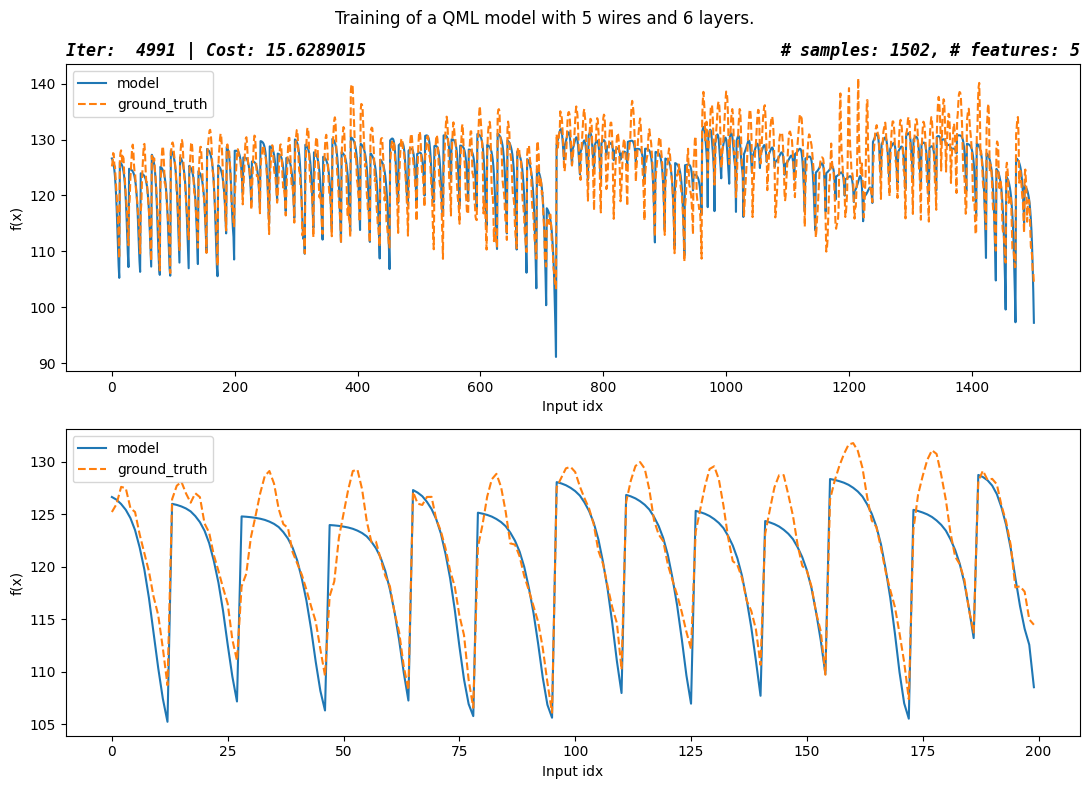

In [37]:
for it in range(5000):
    train_cost, grads = jax.value_and_grad(cost)(params, X_train, Y_train)
    updates, opt_state = optimizer.update(grads, opt_state)
    # s_temp = params['s']
    params = optax.apply_updates(params, updates)
    # params['s']=s_temp
    
    model_plot = variational_classifier(params['w'], params['s'], params['a'], X)
    test_cost = cost(params, X_test, Y_test)
    test_loss.append(test_cost)
    train_loss.append(train_cost)
    
    if it%10==0:
        clear_output(wait=True)
        fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(11, 8))
        ax0.set_title(f"Iter: {it + 1:5d} | Cost: {test_cost:0.7f}", fontsize='large', loc='left', fontweight='bold', style='italic', family='monospace')
        ax0.set_title(f"# samples: {X.shape[0]}, # features: {X.shape[1]}", fontsize='large', loc='right', fontweight='bold', style='italic', family='monospace')
        plt.suptitle(f"""Training of a QML model with {NUM_DIMENSIONS} wires and {NUM_LAYERS} layers.""")
        ax0.set_ylabel("f(x)")
        ax0.set_xlabel("Input idx")
        ax0.plot(model_plot, label='model')
        ax0.plot(Y, linestyle='dashed',label='ground_truth')
        ax0.legend()
        ax1.set_ylabel("f(x)")
        ax1.set_xlabel("Input idx")
        ax1.plot(model_plot[:200], label='model')
        ax1.plot(Y[:200], linestyle='dashed',label='ground_truth')
        ax1.legend()
        plt.tight_layout()
        plt.savefig(f"images/training_{it}")
        plt.show()

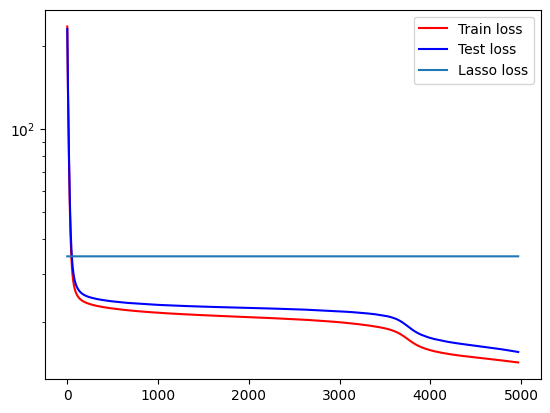

In [61]:
x = list(range(len(train_loss[30:])))
y = [lasso_loss for _ in x]
plt.plot(train_loss[30:], color="red", label="Train loss")
plt.plot(test_loss[30:], color="blue", label="Test loss")
plt.plot(x, y, label="Lasso loss")
plt.yscale('log')
plt.legend()
plt.show()